### Dependencies

##### Installation

In [9]:
%pip install -r requirements.txt



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##### Imports

In [10]:
from rembg import remove

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor


### Remove background of pH strip

##### Remove background

In [11]:
input_path = 'assets/strip.png'
output_path = 'output/strip_withouth_bg.png'

input = cv2.imread(input_path)
output = remove(input)
cv2.imwrite(output_path, output)

True

##### Plot strips

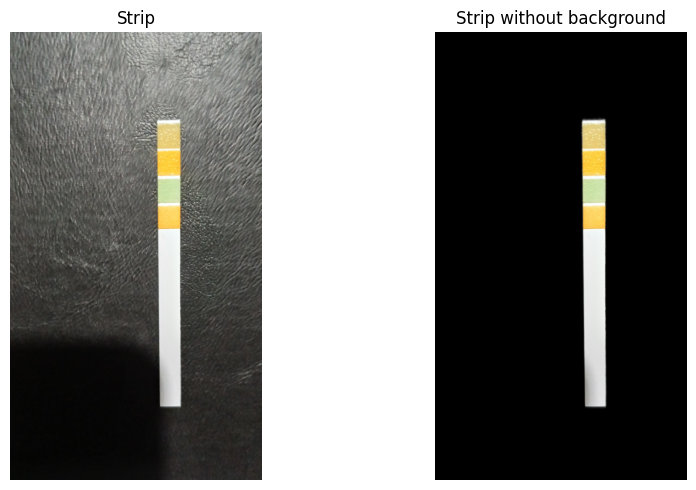

In [12]:
strip = cv2.imread(input_path)
strip_without_bg = cv2.imread(output_path)


strip_rgb = cv2.cvtColor(strip, cv2.COLOR_BGR2RGB)
strip_without_bg_rgb = cv2.cvtColor(strip_without_bg, cv2.COLOR_BGR2RGB)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(strip_rgb)
axs[0].set_title('Strip')
axs[0].axis('off')

axs[1].imshow(strip_without_bg_rgb)
axs[1].set_title('Strip without background')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Balance strip

##### Rotate strip

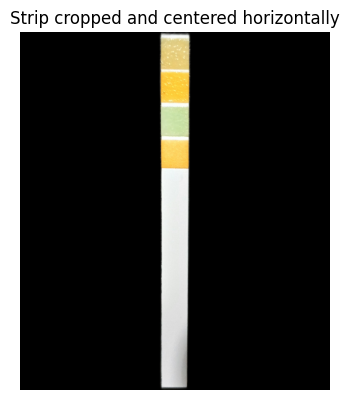

True

In [13]:
image_without_bg = cv2.imread('output/strip_withouth_bg.png')
gray = cv2.cvtColor(image_without_bg, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)

rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)

angle = rect[-1]
width, height = rect[1]

if width < height:
    corrected_angle = angle
else:
    corrected_angle = angle + 90

(h, w) = image_without_bg.shape[:2]
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, corrected_angle, 1.0)
rotated = cv2.warpAffine(image_without_bg, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
rotated = cv2.flip(rotated, 0)

gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
_, binary_rotated = cv2.threshold(gray_rotated, 10, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(binary_rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

x, y, w, h = cv2.boundingRect(largest_contour)

# Recorte vertical
cropped = rotated[y:y+h, :]

# Centralizar a fita horizontalmente
# Detectar novamente a posição horizontal da fita no recorte
gray_crop = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
_, binary_crop = cv2.threshold(gray_crop, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_crop, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x_crop, y_crop, w_crop, h_crop = cv2.boundingRect(largest_contour)

# Calcular os tamanhos de padding para centralizar horizontalmente
total_width = cropped.shape[1]
center_x = total_width // 2
strip_center_x = x_crop + w_crop // 2
shift = center_x - strip_center_x

# Criar imagem com padding à esquerda ou à direita
if shift > 0:
    # Adiciona padding à esquerda
    padded = cv2.copyMakeBorder(cropped, 0, 0, shift, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    # Corta o excesso à direita para manter a largura original
    padded = padded[:, :total_width]
elif shift < 0:
    # Adiciona padding à direita
    padded = cv2.copyMakeBorder(cropped, 0, 0, 0, -shift, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    # Corta o excesso à esquerda
    padded = padded[:, -shift:]
else:
    padded = cropped  # já está centralizada

# Mostrar imagem centralizada
plt.figure(figsize=(4, 8))
plt.imshow(cv2.cvtColor(padded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Strip cropped and centered horizontally')
plt.show()
cv2.imwrite('output/strip_cropped_and_centered.png', padded)



##### Colour balance

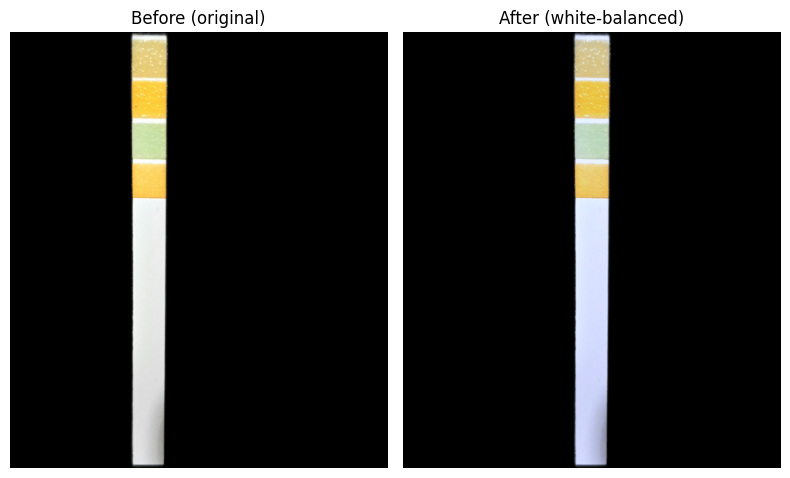

True

In [14]:
def white_balance_gray_world(img):
    result = img.copy().astype(np.float32)

    avg_b = np.mean(result[:, :, 0])
    avg_g = np.mean(result[:, :, 1])
    avg_r = np.mean(result[:, :, 2])

    avg_gray = (avg_b + avg_g + avg_r) / 3

    result[:, :, 0] *= avg_gray / avg_b
    result[:, :, 1] *= avg_gray / avg_g
    result[:, :, 2] *= avg_gray / avg_r

    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

white_balanced = white_balance_gray_world(padded)

fig, axs = plt.subplots(1, 2, figsize=(8, 10))
3
axs[0].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
axs[0].set_title('Before (original)')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(white_balanced, cv2.COLOR_BGR2RGB))
axs[1].set_title('After (white-balanced)')
axs[1].axis('off')

plt.tight_layout()
plt.show()
cv2.imwrite('output/strip_white_balanced.png', white_balanced)


### Extract RGBA

##### Extract with "rule of 3"

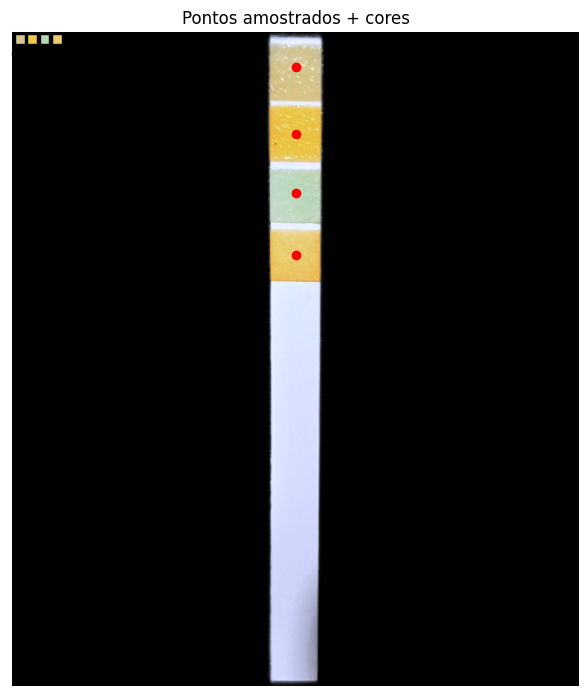

True

In [15]:
height_px = white_balanced.shape[0]
fita_cm = 16.7

x_center = white_balanced.shape[1] // 2

medidas_cm = {
    'Q1': 0.9,
    'Q2': 2.6,
    'Q3': 4.1,
    'Q4': 5.7,
}
def cm_to_px(cm):
    return int((cm / fita_cm) * height_px)

points = {label: (x_center, cm_to_px(cm)) for label, cm in medidas_cm.items()}

fig, ax = plt.subplots(figsize=(6, 10))
ax.imshow(cv2.cvtColor(white_balanced, cv2.COLOR_BGR2RGB))
ax.axis('off')
ax.set_title('Pontos amostrados + cores')

swatch_size = 40
squares = {}
for i, (label, (x, y)) in enumerate(points.items()):
    color_bgr = white_balanced[y, x]
    color_rgb = tuple(int(c) for c in color_bgr[::-1])
    
    squares[f'Q{i+1}'] = color_rgb
    
    ax.plot(x, y, 'ro', markersize=6)

    swatch_x = 10 + i * (swatch_size + 10)
    swatch_y = 10
    rect = Rectangle((swatch_x, swatch_y), swatch_size, swatch_size,
                     linewidth=1, edgecolor='black', facecolor=np.array(color_rgb) / 255)
    ax.add_patch(rect)
    ax.text(swatch_x + swatch_size / 2, swatch_y + swatch_size + 12,
            label, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()
cv2.imwrite('output/strip_sampled_points.png', cv2.cvtColor(white_balanced, cv2.COLOR_BGR2RGB))



### Predict pH

##### Get scale (from a LabelStudio annotation)

In [16]:
image = cv2.imread("artifacts/scale.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width = image.shape[:2]

with open("artifacts/annotations.json") as f:
    annotations = json.load(f)

points_by_label = {"Q1": [], "Q2": [], "Q3": [], "Q4": []}

for result in annotations[0]['annotations'][0]['result']:
    label = result['value']['keypointlabels'][0]
    x_pct = result['value']['x']
    y_pct = result['value']['y']

    x = int(x_pct / 100 * img_width)
    y = int(y_pct / 100 * img_height)

    r, g, b = image_rgb[y, x]
    points_by_label[label].append((r, g, b))

num_points = 30
assert all(len(points_by_label[q]) == num_points for q in ["Q1", "Q2", "Q3", "Q4"])

ph_values = [i * 0.5 for i in range(num_points)]
data = []

for i, ph in enumerate(ph_values):
    row = [ph]
    for q in ["Q1", "Q2", "Q3", "Q4"]:
        r, g, b = points_by_label[q][i]
        row.extend([r, g, b])
    data.append(row)

columns = ["pH"]
for i in range(1, 5):
    columns += [f"R{i}", f"G{i}", f"B{i}"]

df = pd.DataFrame(data, columns=columns)

df.to_csv("artifacts/ph-scale-dataset.csv", index=False)
print("✅ Generated csv: ph-scale-dataset.csv")
df.head()


✅ Generated csv: ph-scale-dataset.csv


,pH,R1,G1,B1,R2,G2,B2,R3,G3,B3,R4,G4,B4
0,0.0,188,115,74,205,136,41,159,188,166,208,156,34
1,0.5,199,121,59,206,138,41,152,181,159,208,153,36
2,1.0,210,129,50,210,138,40,157,179,143,209,155,33
3,1.5,199,130,26,212,137,36,156,177,146,199,146,18
4,2.0,198,136,27,201,134,30,153,175,137,200,144,25


##### Predict with kNN

In [17]:
X = df.drop(columns=["pH"])
y = df["pH"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_scaled, y)


features_raw = list(squares.values())
features_flat = [channel for rgb in features_raw for channel in rgb]

features_normalizado = scaler.transform([features_flat])

ph_predict = knn.predict(features_normalizado)
print("📈 pH predict with kNN model:", ph_predict[0])

📈 pH predict with kNN model: 3.5


/home/vic/.pyenv/versions/phia/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
